<a href="https://colab.research.google.com/github/SyedJawadShah/Intro/blob/master/Hackthon2020_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-sentencepiece


     |████████████████████████████████| 2.1MB 2.8MB/s 


In [ ]:
# Regular modules for data science and visualization:
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random


# Keras (2.2.4) and tensorflow (1.13).
import tensorflow as tf
import tensorflow_hub as hub
import tf_sentencepiece

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend
from keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Density:
p = 0.4
df = pd.read_csv('/content/drive/My Drive/data/articles2.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)
#First batch:
n_s_a = df[df[3] == 'Atlantic']
n_s_p = df[df[3] == 'New York Post']
#Second batch:
df = pd.read_csv('/content/drive/My Drive/data/articles1.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)
n_s_b = df[df[3] == 'Breitbart']
n_s_n = df[df[3] == 'New York Times']

In [ ]:
n_s = list(n_s_b.iloc[:,9].values) + list(n_s_p.iloc[:,9].values) \
 + list(n_s_a.iloc[:,9].values) + list(n_s_n.iloc[:,9].values)

In [ ]:
n_s = [word.replace('New York Post','') for word in n_s]
n_s = [word.replace('Breitbart','') for word in n_s]
n_s = [word.replace('New York Times','') for word in n_s]
n_s = [word.replace('Atlantic','') for word in n_s]

In [ ]:
#Outlet classifier:
classes_All = np.asarray([1 for i in range(len(n_s_b))] + \
[2 for i in range(len(n_s_p))] + [3 for i in range(len(n_s_a))] + \
[4 for i in range(len(n_s_n))])
#Bias classifier:
classes_Bias = np.asarray([1 for i in range(len(n_s_b))] + \
[1 for i in range(len(n_s_p))] + [2 for i in range(len(n_s_a))] + \
[2 for i in range(len(n_s_n))])

In [ ]:
# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.Session(graph=g)
session.run(init_op)

#Function to compute all embeddings for each sentence:
#Be patient, takes a little while:
def similarity_matrix(merge_list):
    #initialize distance array:
    #initialize embeddings array:
    emb_all = np.zeros([len(merge_list),512])
    #Outer for loop:
    for i in range(0,len(merge_list)):
        #Here is where we run the previously started session, so it is important to run previous step succesfully:
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
    return emb_all

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
e_All = similarity_matrix(n_s)

In [ ]:
#Choose optimizer:
optim = optimizers.Adam(lr=0.00015) 

# create NN for news clissification:
news_DNN = Sequential()
news_DNN.add(Dense(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))
news_DNN.add(Dense(40, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))


# Output layer with multiclass activation function:
news_DNN.add(Dense(4,activation='softmax'))

# Compile model:
news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [ ]:
# split into shuffled folds:
#Note that you should edit the class array accordingly: Bias (classes_Bias) or Outlet (classes_All)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # chose one split to make analysis faster. change it if required
for t, te in sss.split(e_All,classes_All):
  # Scale the data with StandardScaler before splitting:
    X_train, X_test = scaler.fit_transform(e_All)[t], \
    scaler.fit_transform(e_All)[te]

    y_train, y_test = classes_All[t]-1,classes_All[te]-1

In [ ]:

#fit the network. You can change parameters to see how this affects your training.
m_h = news_DNN.fit(X_train, y_train, epochs=400, \
validation_data=(X_test, y_test), batch_size=32, verbose=0)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,news_DNN.predict_classes(X_test))

ValueError: ignored

In [ ]:

#Resampling:
[X_train_r, y_train_r] = SMOTE().fit_resample(X_train, y_train)

#model fitting:
m_h = news_DNN.fit(X_train_r, y_train_r, epochs=400, \
validation_data=(X_test, y_test), batch_size=32, verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


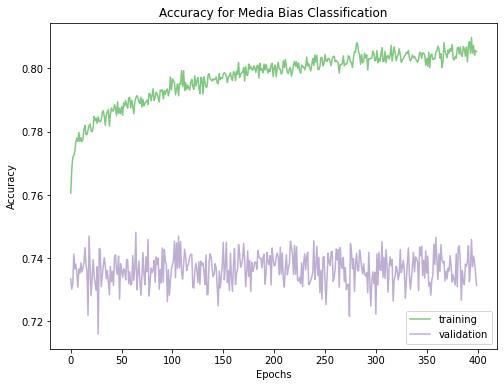

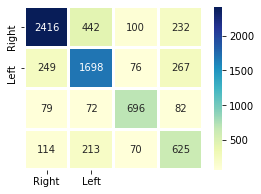

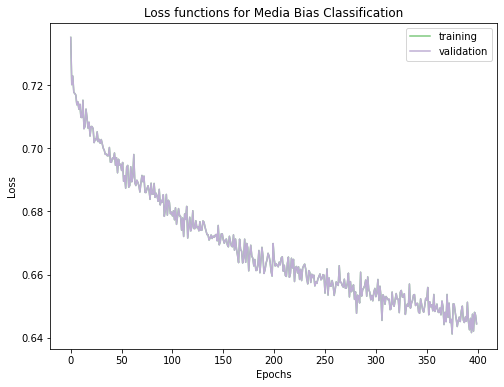

In [ ]:
# Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['acc']))
    sns.lineplot(data=np.asarray(m_h.history['val_acc']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Bias Classification") # change title here
    plt.legend(labels=['training', 'validation'],loc='lower right')
    #plt.text(330,0.755,'val Ac = ' + str(round(accuracy_score(y_test,news_DNN.predict_classes(X_test)),2))) 
    plt.savefig('outlets_bias_acc.svg',format='svg') # edit file title here

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,news_DNN.predict_classes(X_test)),annot=True,linewidths=2, cmap="YlGnBu",fmt="g", xticklabels=['Right','Left'],yticklabels=['Right','Left']) # Or change labels to ['outlet1','outlet2','outlet3','outlet4'] for outlet classifier
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here


# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Bias Classification") #change title here
    plt.legend(labels=['training', 'validation'])
    plt.savefig('outlets_bias_loss.svg',format='SVG') # edit file title here